In [1]:
#| echo: false
piezo = 1069

In [2]:
#| echo: false
# Injected Parameters
piezo = 1069


In [3]:
#| echo: false
#| output: false

import os
from dotenv import load_dotenv, find_dotenv
import boto3
import sagemaker
import pandas as pd
from prophet import Prophet
import matplotlib
import matplotlib.pyplot as plt

# Gestion des logs
import warnings
from pandas.errors import SettingWithCopyWarning
import logging
from urllib3.exceptions import InsecureRequestWarning
from urllib3 import disable_warnings
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
warnings.filterwarnings('ignore') 
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
disable_warnings(InsecureRequestWarning)
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('prophet').disabled = True
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

load_dotenv()

sess = sagemaker.Session(
    boto3.session.Session(region_name=os.environ.get("AWS_DEFAULT_REGION"))
)

bucket = os.environ.get("BUCKET")
role = os.environ.get("AWS_ROLE")
s3 = boto3.client("s3")

path_root = 'water-level-static-staging'
bucket='emi-forercast-amazon-sagemaker'
prefix = f"water-level-static-staging/stations/{piezo}/benchmark_results"

In [4]:
#| echo: false
from IPython.display import Markdown
display(Markdown(f"""# Piezo ID = <span style="color: #0000FF">{piezo}</span>
"""))

# Piezo ID = <span style="color: #0000FF">1069</span>


## Analyse pour les prévisions J+1 à J+20

### MAE (Mean absolute error)

- Cette métrique mesure la moyenne des écarts absolus entre les valeurs prédites par le modèle et les valeurs réelles
⇒ métrique facile à interpréter : la MAE est exprimée dans les mêmes unités que la variable que l’on essaie de prédire.

In [5]:
#| echo: false
#| output: false

s3.download_file(Bucket=bucket, Key=f"{prefix}/{piezo}_ml_mae_global.csv",Filename="downloaded_mae.csv")
df_mae = pd.read_csv('downloaded_mae.csv')

In [6]:
#| echo: false

from IPython.display import display

display(df_mae)

,periode,mae,amplitude moyenne
0,draining,0.051633,1.254706
1,global,0.067102,1.254706


### Comparatif Observations VS Prédictions (modèle J+10 et J+20)

1. Comparaison des prédictions obtenues avec le modèle qui prédit à horizon **+10 jours** avec les réelles observations

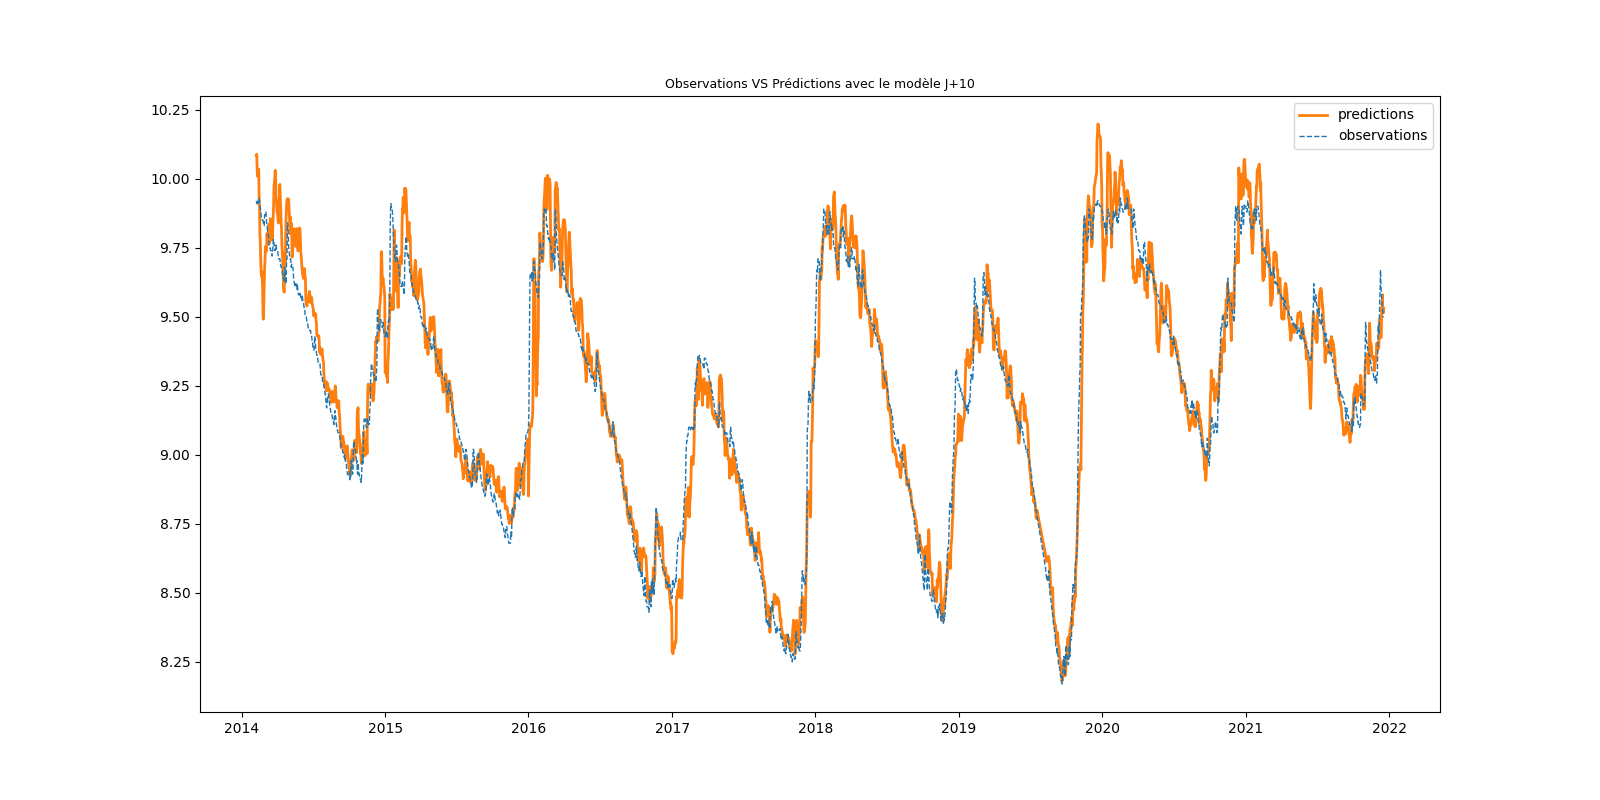

In [7]:
#| echo: false

from IPython.display import Image
s3.download_file(Bucket=bucket, Key=f"{prefix}/{piezo}_10_ml_obs_vs_pred.png",Filename="downloaded_10_obs_vs_pred.png")
Image(filename="downloaded_10_obs_vs_pred.png") 

2. Comparaison des prédictions obtenues avec le modèle qui prédit à horizon +20 jours avec les réelles observations

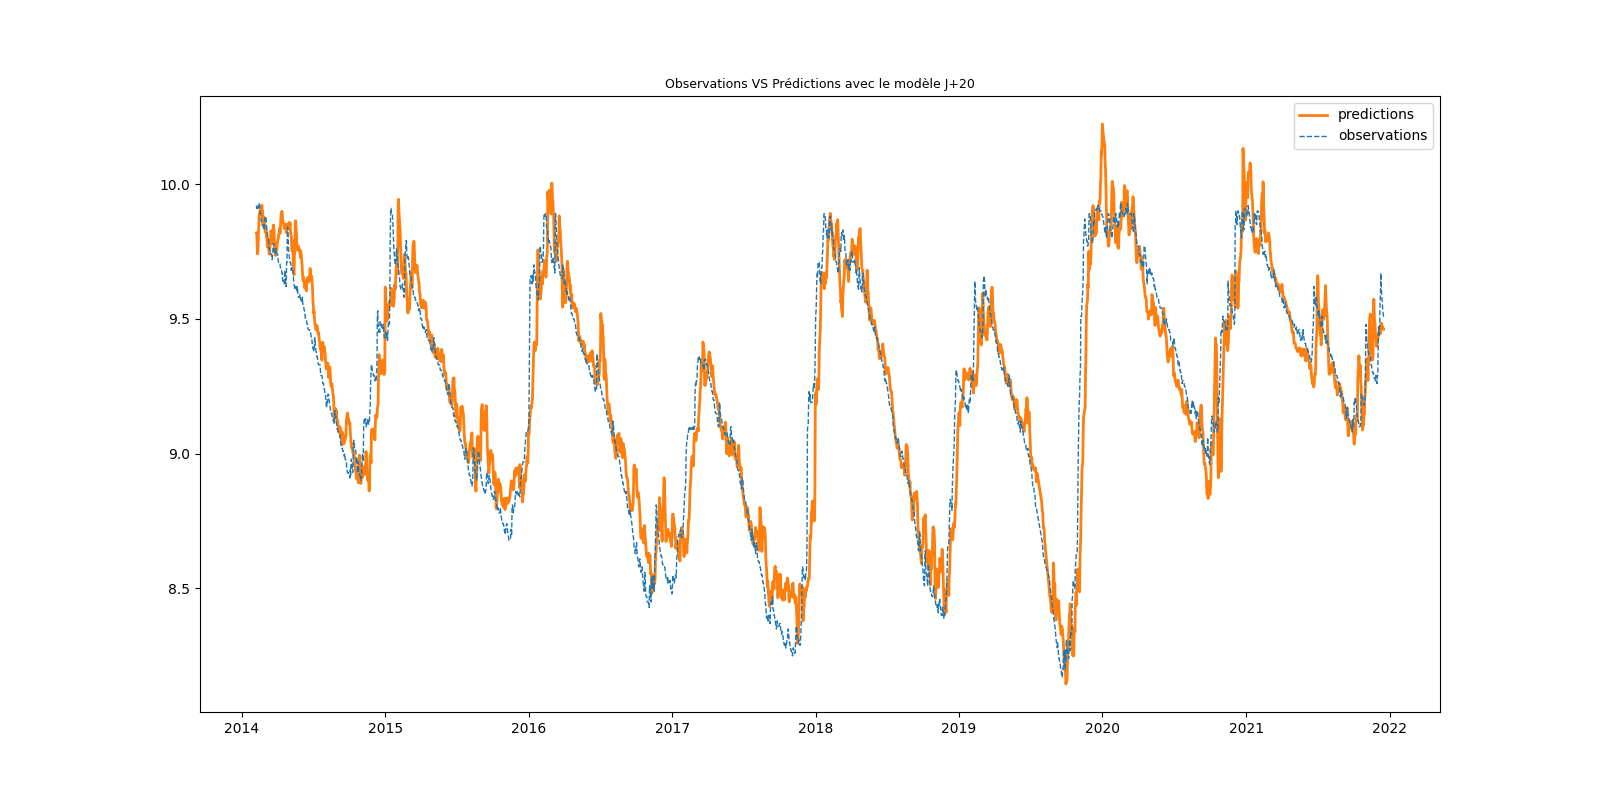

In [8]:
#| echo: false

from IPython.display import Image
s3.download_file(Bucket=bucket, Key=f"{prefix}/{piezo}_20_ml_obs_vs_pred.png",Filename="downloaded_20_obs_vs_pred.png")
Image(filename="downloaded_20_obs_vs_pred.png") 

## Analyse pour les prévisions J+21 à J+90

### Calcul MAE

1. MAE globale sur la période J+21 à J+90 pour les différents modèles

In [9]:
#| echo: false
#| output: false

from sklearn.metrics import mean_absolute_error

list_df_prophet_mae = []
for year in [2019,2020,2021,2022]:
    try:
        s3.download_file(Bucket=bucket, Key=f"{prefix}/{piezo}_{year}_prophet_mae_global.csv",Filename=f"downloaded_{year}_mae.csv")
        tmp = pd.read_csv(f"downloaded_{year}_mae.csv")
        tmp['year']=year
        list_df_prophet_mae.append(tmp)
        del temp
    except:
        continue

df_prophet_mae_by_year = pd.concat(list_df_prophet_mae, ignore_index=True)

df_prophet_mae = df_prophet_mae_by_year.groupby(['type_prediction']).mean()
df_prophet_mae = df_prophet_mae.drop(['year'],axis=1)

In [10]:
#| echo: false

from IPython.display import display

display(df_prophet_mae)

,MAE
type_prediction,
baseline,0.374749
prophet,0.220157
prophet_quantiles,0.111922


2. MAE par année sur la période J+21 à J+90 pour les différents modèles

In [11]:
#| echo: false

from IPython.display import display

display(df_prophet_mae_by_year)

,type_prediction,MAE,year
0,baseline,0.338366,2019
1,prophet,0.378090,2019
2,prophet_quantiles,0.217494,2019
3,baseline,0.343705,2020
4,prophet,0.155065,2020
5,prophet_quantiles,0.071540,2020
6,baseline,0.442177,2021
7,prophet,0.127317,2021
8,prophet_quantiles,0.046732,2021


### Prévision de l'étiage 

- Ce graphique mesure de l'écart en jours (à gauche) et en valeur (à droite) entre l'étiage réel observé **par année** et l'étiage prédit.

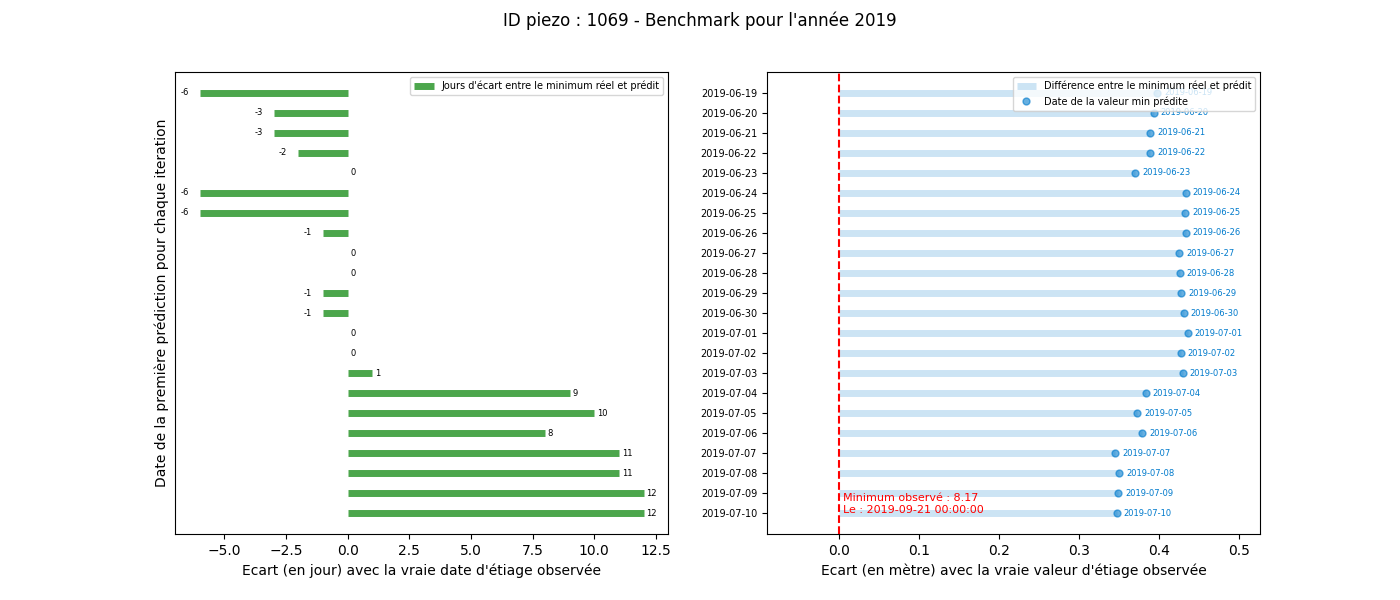

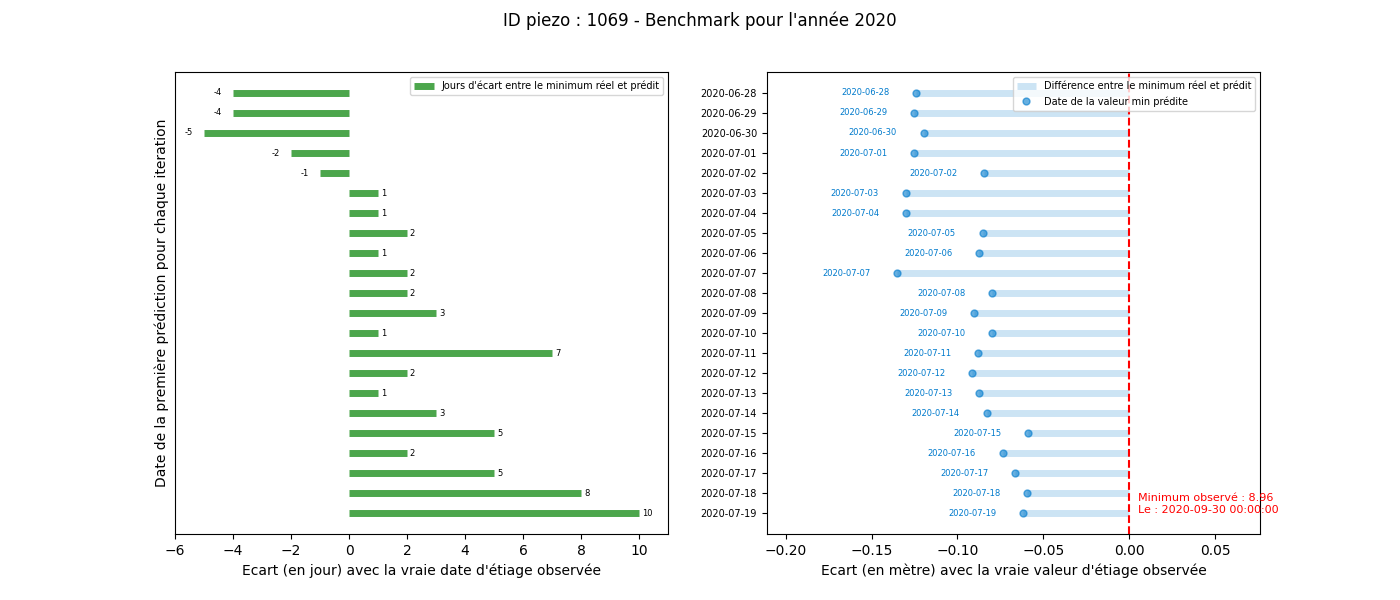

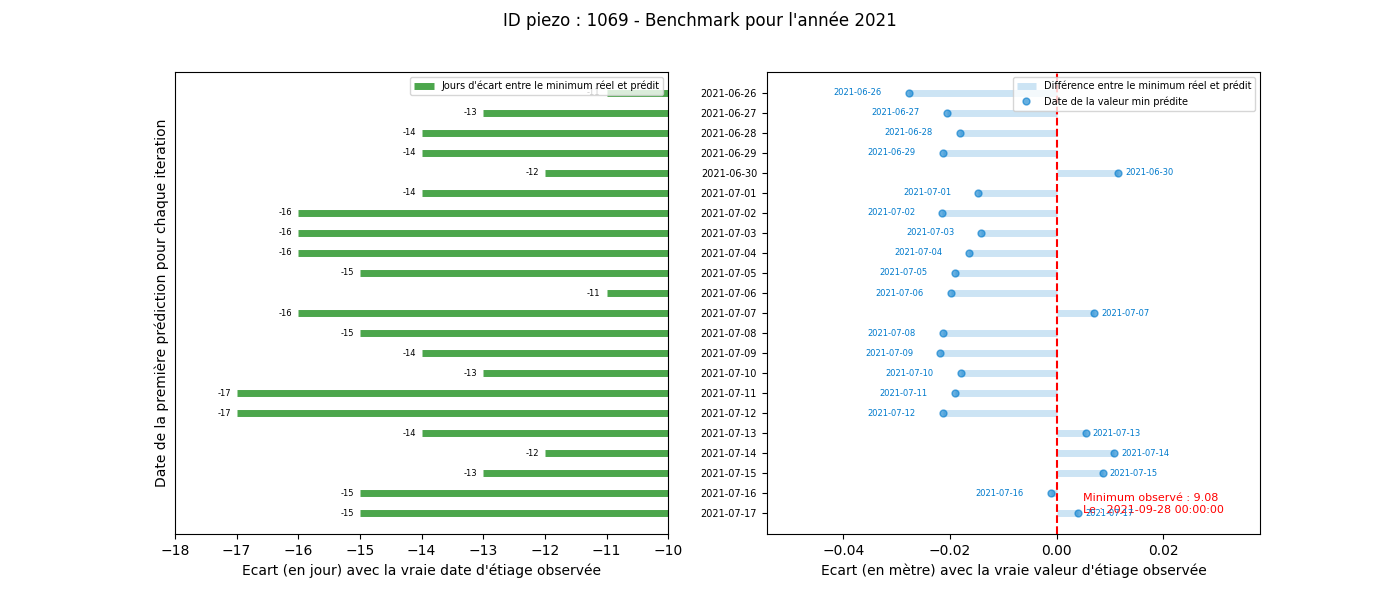

In [12]:
#| echo: false

from IPython.display import Image

for year in [2019,2020,2021,2022]:
    try:
        s3.download_file(Bucket=bucket, Key=f"{prefix}/{piezo}_{year}_dataviz_etiage.png",Filename=f"downloaded_{year}_etiage.png")
        display(Image(filename=f"downloaded_{year}_etiage.png"))
    except:
        continue

In [13]:
#| echo: false
#| output: false

list_files_to_remove = ["downloaded_20_obs_vs_pred.png","downloaded_10_obs_vs_pred.png","downloaded_mae.csv",
                        "downloaded_2019_etiage.png",'downloaded_2020_etiage.png','downloaded_2021_etiage.png','downloaded_2022_etiage.png',
                        "downloaded_2019_mae.csv","downloaded_2020_mae.csv","downloaded_2021_mae.csv","downloaded_2022_mae.csv"]
for f in list_files_to_remove:
    try:
        os.remove(f)
    except:
        continue